<hr style="border:2px solid gray"> </hr>
<img src="https://mma.prnewswire.com/media/1095203/East_Tennessee_State_University_Logo.jpg?p=facebook" width=200 height=200 />

<div class="alert alert-block alert-info">
    <h1 style="text-align: center">CSCI 5037 - NLP & Text Analysis</h1>
</div>

# <center>Lab 8 - Sequence Modeling</center>

**<center>Dr. Ahmad Al-Doulat </center>**
<center>Department of Computing </center>
<center>East Tennessee State University</center>

<hr style="border:2px solid lightblue"> </hr>

**In this assignment, you'll get to practice the concepts and skills covered in the course so far. The main objective of this assignment is to implement and use some of the tools, algorithms, and techniques to perform sentiment analysis on textual data..**



**Guidelines**
* Download `AmazonReviews.csv` file from D2L. 
* Make sure to run all the code cells, otherwise you may get errors like `NameError` for undefined variables.
* Do not change variable names, delete cells or disturb other existing code. It may cause problems during evaluation.
* In some cases, you may need to add some code cells or new statements before or after the line of code containing the `???`.
* Use markdown cells to write your discussions and reflections. 

**Procedure**
* Save your work as `IPYNB` file named `Lab8.ipynb` and submit to D2L `Lab 8 - Sequence Modeling (Dropbox)` by the due date.
* As you go through this notebook, you will find the symbol `???` in certain places. To complete this assignment, you must replace all the `???` with appropriate values, expressions or statements to ensure that the notebook runs properly end-to-end.
* Include your response for `Part 1` and `Part 2` in this notebook. 

<div class="alert alert-block alert-info">

# Part 1: Activity 

</div>

#### Read the content of the `AmazonReviews.csv` into a dataframe called `reviews_df` and perform the following:
1. **Preprocess the `reviews_df` dataframe to prepare it for the following questions.**

2. **Build a SimpleRNN Network to predict the sentiment of each review. Then, evaluate the performance of the model in terms of loss and accuracy** 

3. **Build a Gated Recurrent Unit to predict the sentiment of each review. Then, evaluate the performance of the model in terms of loss and accuracy** 

4. **Build a Long Short-Term Memory Model to predict the sentiment of each review. Then, evaluate the performance of the model in terms of loss and accuracy** 

5. **Which model performs better and why?** 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

np.random.seed(123)       
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import watermark

%load_ext watermark
%matplotlib inline

In [3]:
%watermark

Last updated: 2024-11-27T01:00:43.439035-05:00

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [4]:
df = pd.read_csv('AmazonReviews.csv')
print(df.shape)
df.head()

(25000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
    
def preprocessor(text):
    
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text


In [6]:
df['preprocessed_reviews'] = df['Text'].apply(preprocessor)
df.head(5)
# show first 5 rows 
print(df.shape)
# printing columns and rows information
print(df.info())

(25000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      25000 non-null  int64 
 1   ProductId               25000 non-null  object
 2   UserId                  25000 non-null  object
 3   ProfileName             24999 non-null  object
 4   HelpfulnessNumerator    25000 non-null  int64 
 5   HelpfulnessDenominator  25000 non-null  int64 
 6   Score                   25000 non-null  int64 
 7   Time                    25000 non-null  int64 
 8   Summary                 25000 non-null  object
 9   Text                    25000 non-null  object
 10  preprocessed_reviews    25000 non-null  object
dtypes: int64(5), object(6)
memory usage: 2.1+ MB
None


In [7]:
top_words=10000
tokenizer = Tokenizer(num_words=top_words)

# Convert reviews to a list
reviews_to_list = df['preprocessed_reviews'].tolist()

# Fit the tokenizer on the reviews
tokenizer.fit_on_texts(reviews_to_list)

# Convert reviews to sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Set maximum words per review TO 500
max_words = 500

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(text_sequences, maxlen=max_words)

# Convert padded sequences to NumPy array
X = np.array(padded_sequences)
# Scores greater than 3 should be 1 and less than 3 is set to 0 for sentiment as positive and negative
df.loc[df['Score'] >= 3, 'sentiment'] = 1
df.loc[df['Score'] < 3, 'sentiment'] = 0 
y = df['sentiment']
print(y)
# Check the shapes of X and y
print("Input shape:", X.shape)
print("Output shape:", y.shape)



0        1.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
24995    1.0
24996    0.0
24997    1.0
24998    1.0
24999    1.0
Name: sentiment, Length: 25000, dtype: float64
Input shape: (25000, 500)
Output shape: (25000,)


In [8]:
top_words = 10000

# The script below uses tfidf and then divides our data into 80% for the training set and 20% for the testing set
vectorizer = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,1))
X_train = vectorizer.fit_transform(df['Text'])[:20000].A 
Y_train = df.sentiment[:20000] 
X_test = vectorizer.fit_transform(df['Text'])[20000:].A
Y_test = df.sentiment[20000:]



In [9]:

X_train = keras.utils.pad_sequences(X_train, maxlen=max_words)
X_test = keras.utils.pad_sequences(X_test, maxlen=max_words)

# SimpleRNN Model 

In [10]:
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_words))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,113 (1.23 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [12]:
SimpleRNNhistory = model.fit(X_train, Y_train,
                   validation_data=(X_test, Y_test),
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8535 - loss: 0.4416 - val_accuracy: 0.8486 - val_loss: 0.4262
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8515 - loss: 0.4204 - val_accuracy: 0.8486 - val_loss: 0.4257
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8500 - loss: 0.4234 - val_accuracy: 0.8486 - val_loss: 0.4251
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.8530 - loss: 0.4178 - val_accuracy: 0.8486 - val_loss: 0.4251
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8489 - loss: 0.4249 - val_accuracy: 0.8486 - val_loss: 0.4252
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8498 - loss: 0.4235 - val_accuracy: 0.8486 - val_loss: 0.4253
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8539 - loss: 0.4162 - val_accuracy: 0.8486 - val_loss: 0.4263
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8528 - loss: 0.4186 - 

In [13]:
def plot_history(history):
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)
    
    epochs = np.array(history.epoch) + 1
    
    ax_lst[0].plot(epochs, history.history['loss'], label='Training')    
    ax_lst[0].plot(epochs, history.history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    ax_lst[1].plot(epochs, history.history['accuracy'], label='Training')    
    ax_lst[1].plot(epochs, history.history['val_accuracy'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)
    
    fig.tight_layout()

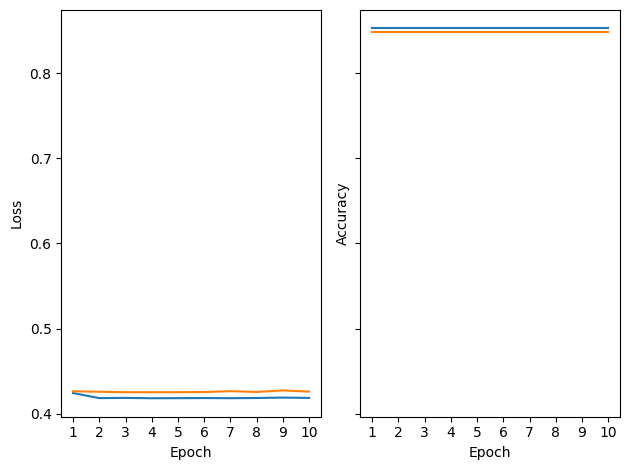

In [14]:
plot_history(SimpleRNNhistory)

In [15]:
SimpleRNNscore = SimpleRNNhistory.model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', SimpleRNNscore[0])
print('Test accuracy:', SimpleRNNscore[1])

Test loss: 0.425857812166214
Test accuracy: 0.8485999703407288


# GRU

In [16]:
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_words))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,369 (1.24 MB)

 Trainable params: 326,369 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [18]:
history = model.fit(X_train, Y_train,
                   validation_data=(X_test, Y_test),
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.8518 - loss: 0.4615 - val_accuracy: 0.8486 - val_loss: 0.4255
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.8581 - loss: 0.4091 - val_accuracy: 0.8486 - val_loss: 0.4252
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.8536 - loss: 0.4165 - val_accuracy: 0.8486 - val_loss: 0.4279
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.8533 - loss: 0.4176 - val_accuracy: 0.8486 - val_loss: 0.4252
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.8524 - loss: 0.4188 - val_accuracy: 0.8486 - val_loss: 0.4251
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.8541 - loss: 0.4158 - val_accuracy: 0.8486 - val_loss: 0.4275
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.8537 - loss: 0.4166 - val_accuracy: 0.8486 - val_loss: 0.4253
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.8521 - loss: 0

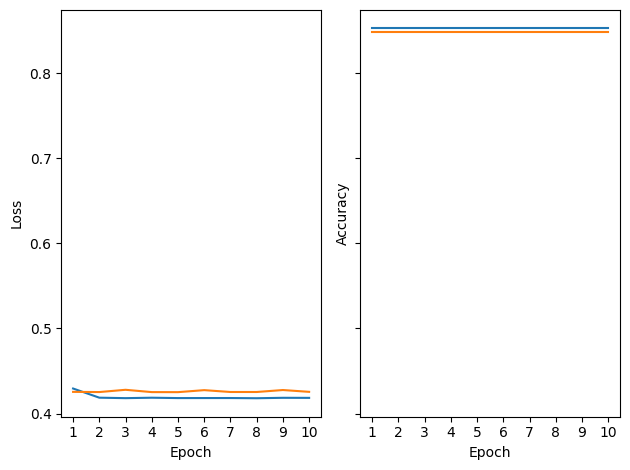

In [19]:
plot_history(history)

In [20]:
GRUscore = history.model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', GRUscore[0])
print('Test accuracy:', GRUscore[1])

Test loss: 0.42549067735671997
Test accuracy: 0.8485999703407288


# LSTM

In [21]:
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_words))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 500, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [23]:
LSTMhistory = model.fit(X_train, Y_train,
                   validation_data=(X_test, Y_test),
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.8286 - loss: 0.4497 - val_accuracy: 0.8486 - val_loss: 0.4257
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.8555 - loss: 0.4136 - val_accuracy: 0.8486 - val_loss: 0.4259
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.8528 - loss: 0.4180 - val_accuracy: 0.8486 - val_loss: 0.4253
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.8548 - loss: 0.4147 - val_accuracy: 0.8486 - val_loss: 0.4257
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8546 - loss: 0.4153 - val_accuracy: 0.8486 - val_loss: 0.4254
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8570 - loss: 0.4104 - val_accuracy: 0.8486 - val_loss: 0.4252
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.8506 - loss: 0.4218 - val_accuracy: 0.8486 - val_loss: 0.4261
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8518 - loss: 0

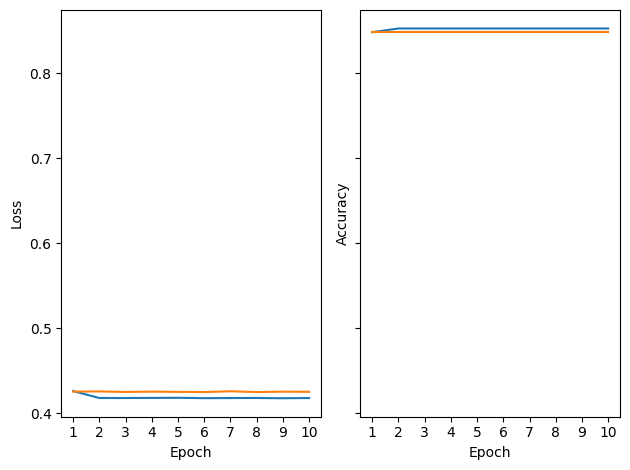

In [24]:
plot_history(LSTMhistory)


In [26]:
LSTMscore = LSTMhistory.model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', LSTMscore[0])
print('Test accuracy:', LSTMscore[1])


Test loss: 0.42545726895332336
Test accuracy: 0.8485999703407288


Evaluation SimpleRNN model showed Test loss of 0.425857812166214 and Test accuracy of 0.8485999703407288

Evaluation GRU Model showed Test loss of 0.42549067735671997 and Test accuracy of 0.8485999703407288

Evaluation OF LTSM model showed Test loss of 0.42545726895332336 and Test accuracy of 0.8485999703407288

The three models have the same accuracy and val accuracy but the longshort term memmory model seems to be the best model here because at the 10th iteration, it seems to minimize the val_loss at the rate of 0.42545726895332336 better the remaining models with an accuracy of 0.8486 so i would conclude that the long short term memmory model performs better.

<div class="alert alert-block alert-info">

# Part 2: Reflection
    
</div>

As a second step—after answering the questions, include the following:
1. A reflection of your experience performing the activity. 
2. A reflection on the importance of learning this activity.
**Note:** include your reflection in this notebook as markdown cells. 

Working on this project introduced me about machine learning and how to separate data sets using the validation approach, as well as the importance of avoiding overfitting.
I also saw that the two losses (loss and val_loss) are falling while the accuracy (acc and val_acc) are growing, indicating that the model is being trained appropriately.The val_acc is a measure of your model's prediction accuracy.This activity used 10 epochs. In case I increase the number of epochs to be very high, it leads to the model overfiting and training accuracy reaches 100%.
This study also shows why we don't need to raise the iteration times because the results would be the same regardless. iv. I also noted that the accuracy and val accuracy remained unchanged, which suggests it's good at the tenth iteration.
A reflection on the value of learning this activity
the loss is the value that a neural network aims to minimize: it is the difference between the ground truth and the predictions. To minimize this distance, the neural network learns by altering weights and biases in a way that reduces loss.



<div class="alert alert-block alert-info">

# Submission
    
</div>

Submit **Lab8.ipynb** to the **Lab 8 - Sequence Modeling (Dropbox)** on D2L by the due date. 

<div class="alert alert-block alert-info">

# Grading Rubric
    
</div>

|Criterion	|Excellent	|Good	|Average	|Below Average	|Poor	|No Attempt|
|:--	|:--	|:--	|:--	|:-- 	|:--	|:-- |
|**Part 1:** Activity-Question 1|	**10 points**- Completes all aspects of the question correctly	|**8 points**- Completes most aspects of the question correctly |**6 points**- Completes aspects of the question  correctly, and some incorrectly	|**4 points**- Completes most aspects of the question  incorrectly or does not attempt many aspects|	**2 points**- Minimal effort or completes a few aspects of the question or very few correctly|**0 points**- Did not complete the question|
|**Part 1:** Activity-Question 2|	**10 points**- Completes all aspects of the question correctly	|**8 points**- Completes most aspects of the question correctly |**6 points**- Completes aspects of the question  correctly, and some incorrectly	|**4 points**- Completes most aspects of the question  incorrectly or does not attempt many aspects|	**2 points**- Minimal effort or completes a few aspects of the question or very few correctly|**0 points**- Did not complete the question|
|**Part 1:** Activity-Question 3|	**10 points**- Completes all aspects of the question correctly	|**8 points**- Completes most aspects of the question correctly |**6 points**- Completes aspects of the question  correctly, and some incorrectly	|**4 points**- Completes most aspects of the question  incorrectly or does not attempt many aspects|	**2 points**- Minimal effort or completes a few aspects of the question or very few correctly|**0 points**- Did not complete the question|
|**Part 1:** Activity-Question 4|	**10 points**- Completes all aspects of the question correctly	|**8 points**- Completes most aspects of the question correctly |**6 points**- Completes aspects of the question  correctly, and some incorrectly	|**4 points**- Completes most aspects of the question  incorrectly or does not attempt many aspects|	**2 points**- Minimal effort or completes a few aspects of the question or very few correctly|**0 points**- Did not complete the question|
|**Part 1:** Activity-Question 5|	**10 points**- Completes all aspects of the question correctly	|**8 points**- Completes most aspects of the question correctly |**6 points**- Completes aspects of the question  correctly, and some incorrectly	|**4 points**- Completes most aspects of the question  incorrectly or does not attempt many aspects|	**2 points**- Minimal effort or completes a few aspects of the question or very few correctly|**0 points**- Did not complete the question|
|**Part 2:** Reflection|**10 points**- Reflection clearly ties to the module content; experience and importance clearly laid out|**8 points**- Reflection mostly ties to the module content; experience & importance are discussed|**6 points**- Reflection ties minimally to the module content; experience & importance are discussed but not thoroughly|**4 points**- Reflection does not tie to the module content; experience & importance are minimally discussed|**2 points**- Minimal effort to tie to content; minimal effort to describe experience/ importance|**0 points**- Did not complete the reflection